# Research Question No. 5
This research question aims to investigate the characteristics of groups of bugs for which classifiers yield better accuracy.

# 1. Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 | NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

# 2. Setup environment

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
import os 
import matplotlib.pyplot  as plt 
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns 
from wordcloud import WordCloud
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 12
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

results_gcc_path = "datasets/20190926143854_rq4e4_gcc_predict_long_lived_tests_balanced_acc.csv"
reports_gcc_path = "datasets/20190917_gcc_bug_report_data.csv"

results_eclipse_path = "datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv"
reports_eclipse_path = "datasets/20190917_eclipse_bug_report_data.csv"

print("Setup complete")

Setup complete


# 3. Load data

In [5]:
    !echo "\nHeader of metrics file $reports_gcc_path"
    !head -n 2 $reports_gcc_path

    !echo "\nNumber of lines in the file $reports_gcc_path"
    !wc -l $reports_gcc_path
    
    !echo "\nHeader of metrics file $results_eclipse_path"
    !head -n 2 $results_eclipse_path

    !echo "\nNumber of lines in the file $results_eclipse_path"
    !wc -l $results_eclipse_path

\nHeader of metrics file datasets/20190917_gcc_bug_report_data.csv
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font.getPSFontName() to return something non-null.,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2
\nNumber of lines in the file datasets/20190917_gcc_bug_report_data.csv
489575 datasets/20190917_gcc_bug_report_data.csv
\nHeader of metrics file datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv
bug_id,bug_fix_time,long_lived,y_hat
4DIAC-489747,139,Y,N
\nNumber of lines in the file datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_ac

In [6]:
# read data.
reports_gcc_data  = pd.read_csv(reports_gcc_path)
rows_and_cols = reports_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_gcc_path}.\n")

results_gcc_data = pd.read_csv(results_gcc_path)
rows_and_cols = results_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_gcc_path}.\n")


reports_eclipse_data  = pd.read_csv(reports_eclipse_path)
rows_and_cols = reports_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_eclipse_path}.\n")

results_eclipse_data = pd.read_csv(results_eclipse_path)
rows_and_cols = results_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_eclipse_path}.\n")


There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

There are 2480 rows and 4 columns in datasets/20190926143854_rq4e4_gcc_predict_long_lived_tests_balanced_acc.csv.

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

There are 2408 rows and 4 columns in datasets/20190926143854_rq4e4_eclipse_predict_long_lived_tests_balanced_acc.csv.



# 4. Test Results Analysis

### 4.1 Review data

In [7]:
results_gcc_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,CLASSPATH-16983,15,N,N
1,CLASSPATH-17008,342,N,N
2,CLASSPATH-17060,337,N,N
3,CLASSPATH-18312,5,N,N
4,CLASSPATH-21635,96,N,N


In [8]:
reports_gcc_data['long_lived_computed']  = reports_gcc_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [9]:
reports_gcc_data['long_lived_computed'].head()

0    short-lived
1    short-lived
2     long-lived
3    short-lived
4    short-lived
Name: long_lived_computed, dtype: object

In [10]:
results_eclipse_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,4DIAC-489747,139,Y,N
1,4DIAC-495630,38,Y,Y
2,4DIAC-500078,38,Y,Y
3,4DIAC-511266,0,N,N
4,4DIAC-518907,200,Y,N


In [11]:
reports_eclipse_data['long_lived_computed']  = reports_eclipse_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [12]:
reports_eclipse_data['long_lived_computed'].head()

0    short-lived
1    short-lived
2    short-lived
3    short-lived
4    short-lived
Name: long_lived_computed, dtype: object

## 4.2 Results analysis

In [13]:
def plot_bar(data, project, status, column, top_all_10, ylims):    
    top_n = data[data['status_prediction']==status]
    top_n = top_n.groupby(column).size().reset_index(name='count')
    top_n = top_n.sort_values('count', ascending=False).head(10)
    
    colors  = top_n[column].apply(lambda t: 'tab:red' if (top_all_10[column] == t).sum() > 0 else 'tab:blue')
    
    plt.bar(top_n[column], top_n['count'], color=colors)
    sns.despine(offset=5)
    
    plt.xticks(rotation='vertical', fontsize=SMALL_SIZE)
    plt.xlabel(column.replace('_', ' ').title(), fontsize=SMALL_SIZE)
    
    plt.yticks(fontsize=SMALL_SIZE)
    plt.ylabel('Count', fontsize=SMALL_SIZE)
    plt.ylim(ylims)
    
    t = status.replace("uncorrected", "False Negative")
    t = t.replace("corrected", "True Positive")
    
    plt.title(f"{project.title()}: {t.title()}")
    
    red_patch = mpatches.Patch(color='tab:red',   label='In Top-10')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not in Top-10')

    plt.legend(handles=[red_patch, blue_patch],  fontsize=SMALL_SIZE)
    
def plot_final_bar(results, reports, project, column, status, ylims):
    sns.set_context("paper")
    sns.set(style="ticks", color_codes=True)
    top_n = reports.groupby([column, "long_lived_computed"]).size().reset_index(name='count')
    top_n = top_n.sort_values('count', ascending=False).head(10)
    plot_bar(results, project, status, column, top_n, ylims)
    plt.savefig(f"figures/rq5-{project}-{column}-{status}-predicted.pdf", format="pdf", dpi=600, bbox_inches='tight')
    
def plot_bar_no_top_n(data, project, status, column, ylims):
    
    top_n = data[data['status_prediction']==status]
    top_n = top_n.groupby(column).size().reset_index(name='count')
    
    plt.bar(top_n[column], top_n['count'], color='tab:blue')
    sns.despine(offset=5)
    
    plt.xticks(rotation='vertical', fontsize=SMALL_SIZE)
    plt.xlabel(column.replace('_', ' ').replace('category', 'level').title(), fontsize=SMALL_SIZE)
    
    plt.yticks(fontsize=SMALL_SIZE)
    plt.ylabel('Count', fontsize=SMALL_SIZE)
    plt.ylim(ylims)
    
    t = status.title().replace("Uncorrected", "False Negative")
    t = t.title().replace("Corrected", "True Positive")
    
    plt.title(f"{project.title()}: {t.title()}")
    
    #red_patch = mpatches.Patch(color='tab:red',   label='Top-10')
    #blue_patch = mpatches.Patch(color='tab:blue', label='Not Top-10')

    #plt.legend(handles=[red_patch, blue_patch],  fontsize=SMALL_SIZE)
def plot_final_bar_no_top_n(results, project, column, status, ylims):
    sns.set_context("paper")
    sns.set(style="ticks", color_codes=True)
    plot_bar_no_top_n(results, project, status, column, ylims)
    plt.savefig(f"figures/rq5-{project}-{column.replace('category', 'level')}-{status}-predicted.pdf", format="pdf", dpi=600, bbox_inches='tight')

In [59]:
def plot_bar_resumo(data, project, status, column, top_all_10, ylims):    
    top_n = data[data['status_prediction']==status]
    top_n['top_n'] = top_n[column].apply(lambda t: 'top_10' if (t in top_all_10[column]) else 'no_top_10')
    top_n = top_n.groupby([column, 'top_n']).size().reset_index(name='count')
    top_n = top_n.sort_values('count', ascending=False).head(10)
    
    #colors  = top_n[column].apply(lambda t: 'tab:red' if (top_all_10[column] == t).sum() > 0 else 'tab:blue')
    
    
    top_n.plot(kind='bar', stacked='True')
    #plt.bar(top_n[column], top_n['count'], color=colors)
    sns.despine(offset=5)
    
    plt.xticks(rotation='vertical', fontsize=SMALL_SIZE)
    plt.xlabel(column.replace('_', ' ').title(), fontsize=SMALL_SIZE)
    
    plt.yticks(fontsize=SMALL_SIZE)
    plt.ylabel('Count', fontsize=SMALL_SIZE)
    plt.ylim(ylims)
    
    t = status.replace("uncorrected", "False Negative")
    t = t.replace("corrected", "True Positive")
    
    plt.title(f"{project.title()}: {t.title()}")
    
    red_patch = mpatches.Patch(color='tab:red',   label='In Top-10')
    blue_patch = mpatches.Patch(color='tab:blue', label='Not in Top-10')

    plt.legend(handles=[red_patch, blue_patch],  fontsize=SMALL_SIZE)
    
def plot_final_bar_resumo(results, reports, project, column, status, ylims):
    sns.set_context("paper")
    sns.set(style="ticks", color_codes=True)
    top_n = reports.groupby([column, "long_lived_computed"]).size().reset_index(name='count')
    top_n = top_n.sort_values('count', ascending=False).head(10)
    plot_bar_resumo(results, project, status, column, top_n, ylims)
    plt.savefig(f"figures/rq5-{project}-{column}-{status}-predicted.pdf", format="pdf", dpi=600, bbox_inches='tight')
    
def plot_bar_no_top_n_resumo(data, project, status, column, ylims):
    
    top_n = data[data['status_prediction']==status]
    top_n = top_n.groupby(column).size().reset_index(name='count')
    
    plt.bar(top_n[column], top_n['count'], color='tab:blue')
    sns.despine(offset=5)
    
    plt.xticks(rotation='vertical', fontsize=SMALL_SIZE)
    plt.xlabel(column.replace('_', ' ').replace('category', 'level').title(), fontsize=SMALL_SIZE)
    
    plt.yticks(fontsize=SMALL_SIZE)
    plt.ylabel('Count', fontsize=SMALL_SIZE)
    plt.ylim(ylims)
    
    t = status.title().replace("Uncorrected", "False Negative")
    t = t.title().replace("Corrected", "True Positive")
    
    plt.title(f"{project.title()}: {t.title()}")
    
    #red_patch = mpatches.Patch(color='tab:red',   label='Top-10')
    #blue_patch = mpatches.Patch(color='tab:blue', label='Not Top-10')

    #plt.legend(handles=[red_patch, blue_patch],  fontsize=SMALL_SIZE)
def plot_final_bar_no_top_n_resumo(results, project, column, status, ylims):
    sns.set_context("paper")
    sns.set(style="ticks", color_codes=True)
    plot_bar_no_top_n(results, project, status, column, ylims)
    plt.savefig(f"figures/rq5-{project}-{column.replace('category', 'level')}-{status}-predicted.pdf", format="pdf", dpi=600, bbox_inches='tight')

In [60]:
results_gcc_merged_data = pd.merge(
    reports_gcc_data,
    results_gcc_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
results_eclipse_merged_data = pd.merge(
    reports_eclipse_data,
    results_eclipse_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)

In [61]:
long_lived_gcc_predicted_bugs = results_gcc_merged_data.query('long_lived == "Y"')
long_lived_gcc_predicted_bugs.loc[:, 'status_prediction']  = long_lived_gcc_predicted_bugs.loc[:, 'y_hat'].apply(lambda t: 'corrected' if t == 'Y' else 'uncorrected')
long_lived_eclipse_predicted_bugs = results_eclipse_merged_data.query('long_lived == "Y"')
long_lived_eclipse_predicted_bugs.loc[:, 'status_prediction']  = long_lived_eclipse_predicted_bugs.loc[:, 'y_hat'].apply(lambda t: 'corrected' if t == 'Y' else 'uncorrected')

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Reporter Name

### GCC

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


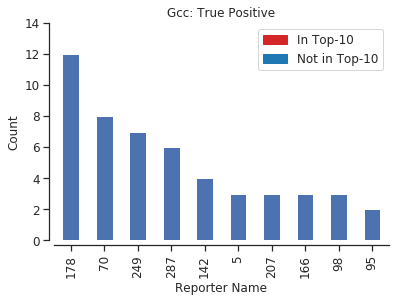

In [62]:
plot_final_bar_resumo(long_lived_gcc_predicted_bugs, reports_gcc_data, 'gcc', 'reporter_name', 'corrected', (0, 14))

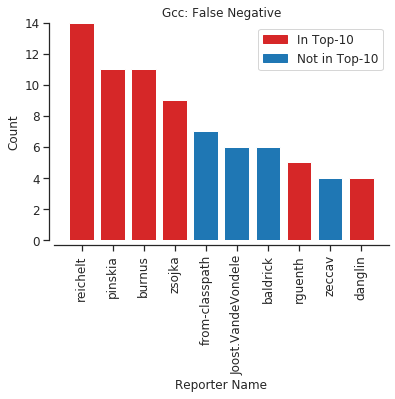

In [18]:
plot_final_bar(long_lived_gcc_predicted_bugs, reports_gcc_data, 'gcc', 'reporter_name', 'uncorrected', (0, 14))

### Eclipse

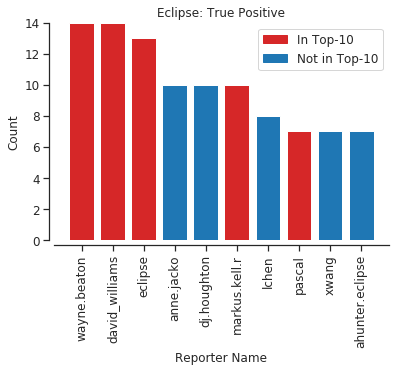

In [19]:
plot_final_bar(long_lived_eclipse_predicted_bugs, reports_eclipse_data, 'eclipse', 'reporter_name', 'corrected', (0, 14))

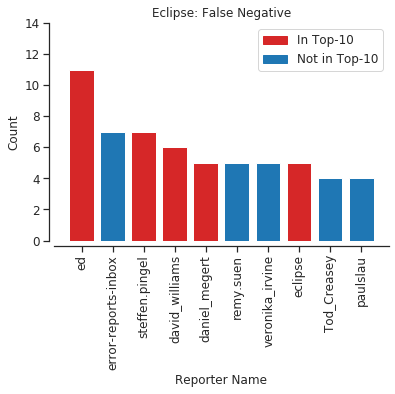

In [20]:
plot_final_bar(long_lived_eclipse_predicted_bugs, reports_eclipse_data, 'eclipse', 'reporter_name', 'uncorrected', (0, 14))

### Assignee

### GCC

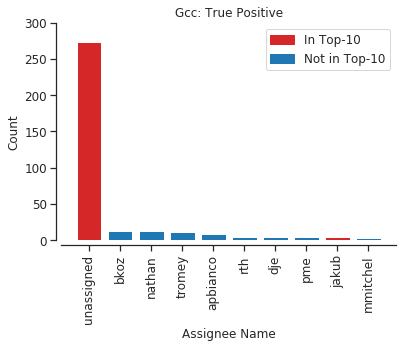

In [21]:
plot_final_bar(long_lived_gcc_predicted_bugs, reports_gcc_data, 'gcc', 'assignee_name', 'corrected', (0, 300))

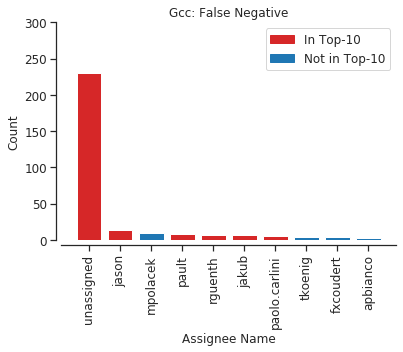

In [22]:
plot_final_bar(long_lived_gcc_predicted_bugs, reports_gcc_data, 'gcc', 'assignee_name', 'uncorrected', (0, 300))

### Eclipse

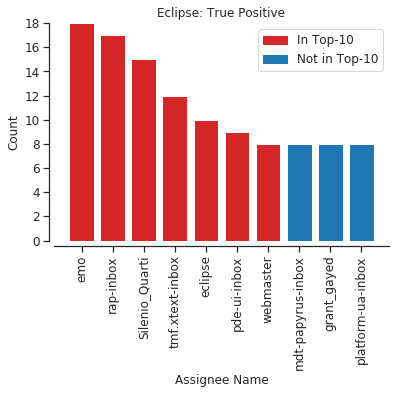

In [23]:
plot_final_bar(long_lived_eclipse_predicted_bugs, reports_eclipse_data, 'eclipse', 'assignee_name', 'corrected', (0, 18))

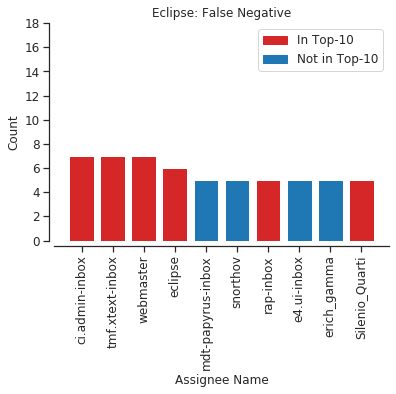

In [24]:
plot_final_bar(long_lived_eclipse_predicted_bugs, reports_eclipse_data, 'eclipse', 'assignee_name', 'uncorrected', (0, 18))

### Component Name

### GCC

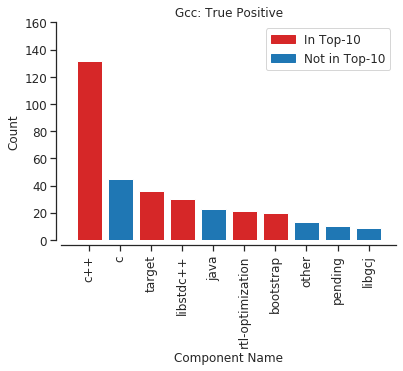

In [25]:
plot_final_bar(long_lived_gcc_predicted_bugs, reports_gcc_data, 'gcc', 'component_name', 'corrected', (0, 160))

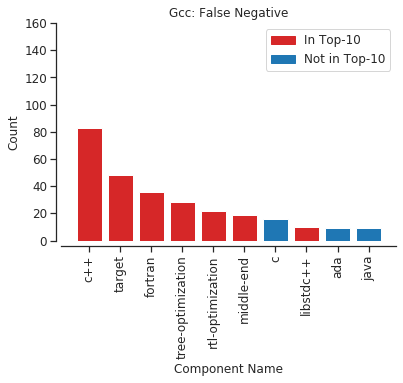

In [26]:
plot_final_bar(long_lived_gcc_predicted_bugs, reports_gcc_data, 'gcc', 'component_name', 'uncorrected', (0, 160))

### Eclipse

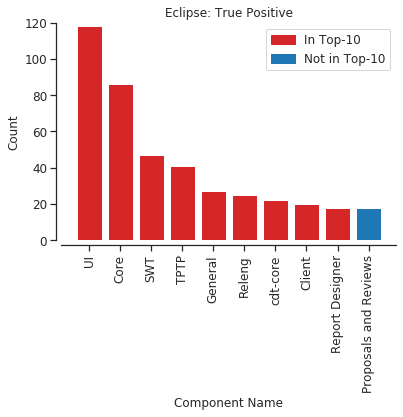

In [27]:
plot_final_bar(long_lived_eclipse_predicted_bugs, reports_eclipse_data, 'eclipse', 'component_name', 'corrected', (0, 120))

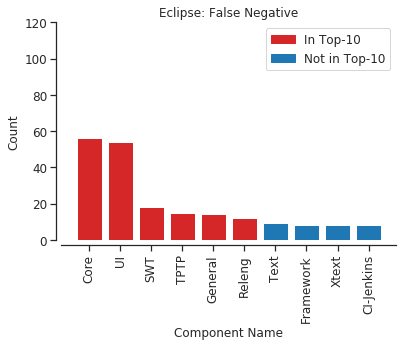

In [28]:
plot_final_bar(long_lived_eclipse_predicted_bugs, reports_eclipse_data, 'eclipse', 'component_name', 'uncorrected', (0, 120))

### Severity Level

### GCC

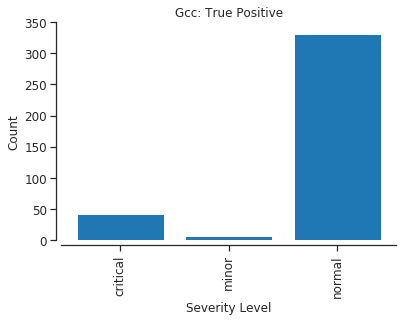

In [29]:
plot_final_bar_no_top_n(long_lived_gcc_predicted_bugs, 'gcc', 'severity_category', 'corrected', (0, 350))

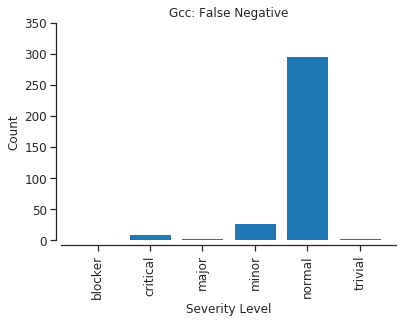

In [30]:
plot_final_bar_no_top_n(long_lived_gcc_predicted_bugs, 'gcc', 'severity_category', 'uncorrected', (0, 350))

### Eclipse

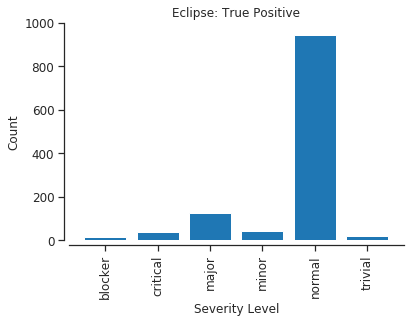

In [31]:
plot_final_bar_no_top_n(long_lived_eclipse_predicted_bugs, 'eclipse', 'severity_category', 'corrected', (0, 1000))

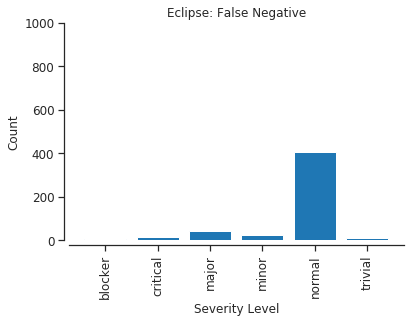

In [32]:
plot_final_bar_no_top_n(long_lived_eclipse_predicted_bugs, 'eclipse', 'severity_category', 'uncorrected', (0, 1000))

### Description 
Existem muitas palavras relacionadas com código(stop words).

In [33]:
word_frequency_gcc_path     = "datasets/20191028080345_gcc_word_frequency.csv"
word_frequency_eclipse_path = "datasets/20191028080345_eclipse_word_frequency.csv"
word_frequency_gcc_data     = pd.read_csv(word_frequency_gcc_path) 
word_frequency_eclipse_data = pd.read_csv(word_frequency_eclipse_path)

word_frequency_gcc_data['freq'] = word_frequency_gcc_data['freq'].astype(int)
word_frequency_eclipse_data['freq'] = word_frequency_eclipse_data['freq'].astype(int)


### GCC

In [34]:
word_frequency_gcc_data.head()

,word,freq,status,project
0,lib,6,Corrected,gcc
1,includ,6,Corrected,gcc
2,linux,6,Corrected,gcc
3,usr,6,Corrected,gcc
4,int,6,Corrected,gcc


In [35]:
from PIL import Image
import matplotlib
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def plot_word_cloud(data, status):
    data = data[data['status']==status]
    cloud_mask = np.array(Image.open("cloud.png"))
    
    #transformed_cloud_mask = np.ndarray((cloud_mask.shape[0], cloud_mask.shape[1]), np.int32)

    #for i in range(len(cloud_mask)):
    #    transformed_cloud_mask[i] = list(map(transform_format, cloud_mask[i]))
    
    word_frequency = {x[0]: x[1] for x in data.itertuples(index=False)}
    wordcloud = WordCloud(width=900
                      , height=500
                      , mask=cloud_mask
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=1
                      , normalize_plurals=False).generate_from_frequencies(word_frequency)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    #plt.title(f"Long-lived {status} Predicted", fontsize=20)
    plt.axis("off")


#### Histograms 

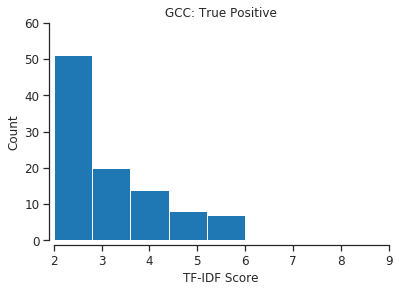

In [36]:
freqs=word_frequency_gcc_data[word_frequency_gcc_data['status']=='Corrected']['freq']

plt.hist(freqs, color='tab:blue', bins=5)
sns.despine(offset=5)

plt.title("GCC: True Positive")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)

plt.savefig('figures/rq5-gcc-tf-idf-corrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

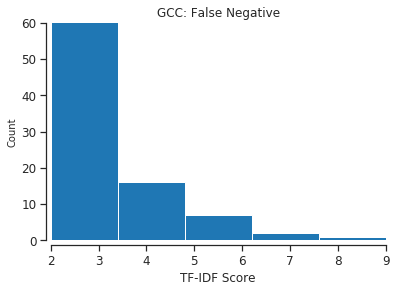

In [37]:
plt.hist(word_frequency_gcc_data[word_frequency_gcc_data['status']=='Incorrected']['freq']
         , bins=5
         , color='tab:blue')
sns.despine(offset=5)
plt.title("GCC: False Negative")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=10)
plt.savefig('figures/rq5-gcc-tf-idf-uncorrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

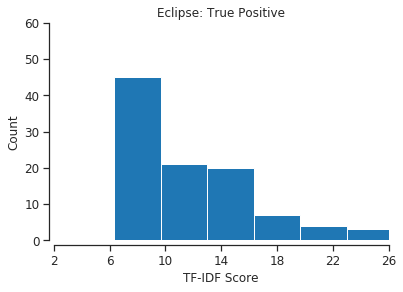

In [38]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status']=='Corrected']['freq'].astype('int')
         , align='left'
         , bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: True Positive")
plt.xticks([2, 6, 10, 14, 18, 22, 26], fontsize=SMALL_SIZE)
plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-corrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

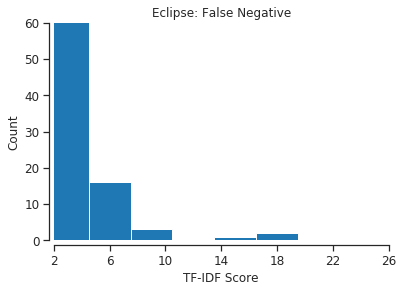

In [39]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status']=='Incorrected']['freq']
         , align='left'
         , bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: False Negative")
plt.xticks([2, 6, 10, 14, 18, 22, 26], fontsize=SMALL_SIZE)
plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-uncorrected-predicted.pdf', format="pdf", dpi=600, bbox_inches='tight')

In [40]:
a = list(word_frequency_gcc_data[word_frequency_gcc_data.status=="Corrected"]['word'])
b = list(word_frequency_gcc_data[word_frequency_gcc_data.status=="Incorrected"]['word'])

In [41]:
len(set(a) | set(b))

143

In [42]:
a = list(word_frequency_eclipse_data[word_frequency_eclipse_data.status=="Corrected"]['word'])
b = list(word_frequency_eclipse_data[word_frequency_eclipse_data.status=="Incorrected"]['word'])

In [43]:
len(set(a) | set(b))

149